# Applied ML Workshop: Fairness, Bias, and Transformers

Must watch: https://youtu.be/kCc8FmEb1nY?si=V9Mp4K3BPNSKhV8L

##  Key Terms & Definitions

### Core Architecture Terms:
- **Transformer**: Neural network architecture that uses self-attention to process sequences in parallel (unlike RNNs that process sequentially).
- **Self-Attention**: Mechanism where each word looks at all other words in the sequence to understand context and relationships.
- **Multi-Head Attention**: Running multiple attention mechanisms in parallel to capture different types of relationships between words.
- **Encoder**: Part of transformer that reads and understands input text by building contextual representations.
- **Decoder**: Part of transformer that generates output text one token at a time based on encoder output and previous predictions.
- **Positional Encoding**: Added information about word positions since transformers process all words simultaneously (unlike RNNs with inherent order).

### Model Components:
- **Token**: Smallest unit of text the model processes (can be word, subword, or character depending on tokenizer).
- **Embedding**: Dense vector representation of a token that captures semantic meaning in continuous space.
- **Query (Q)**: In attention, the representation asking "what am I looking for?" for context.
- **Key (K)**: In attention, the representation answering "what information do I have?" for matching.
- **Value (V)**: In attention, the actual information content retrieved based on Query-Key similarity.
- **Attention Scores**: Similarity values between Query and Keys that determine which words to focus on.
- **Feed-Forward Network**: Fully connected layers applied to each position independently after attention.
- **Layer Normalization**: Technique to stabilize training by normalizing activations within each layer.
- **Residual Connections**: Skip connections that add layer input to its output to help gradient flow during training.

### Training & Fine-tuning:
- **Pretraining**: Initial training on massive text corpora (e.g., all of Wikipedia) to learn general language patterns.
- **Fine-tuning**: Additional training on specific task data to adapt pretrained model to specialized use cases.
- **Transfer Learning**: Using knowledge from pretraining to solve new tasks with less data and compute.
- **Masked Language Modeling (MLM)**: Pretraining task where random words are hidden and model learns to predict them (used in BERT).
- **Causal Language Modeling**: Pretraining task where model predicts next word given previous words (used in GPT).

### Popular Model Families:
- **BERT**: Bidirectional transformer encoder designed for understanding tasks (classification, question answering, NER).
- **GPT**: Unidirectional transformer decoder designed for generation tasks (text completion, dialogue, summarization).
- **T5**: Encoder-decoder transformer that frames all tasks as text-to-text (translate, summarize, answer questions).
- **DistilBERT/DistilGPT2**: Smaller, faster versions created through knowledge distillation while retaining ~95% performance.

### Application Concepts:
- **Zero-Shot Learning**: Model performs task with no training examples, just task description in prompt.
- **Few-Shot Learning**: Model learns task from just a few examples provided in prompt (typically 1-10 examples).
- **Prompt Engineering**: Crafting input text to guide model toward desired output format, tone, or content.
- **Context Window**: Maximum number of tokens model can process at once (e.g., 512, 2048, 4096 tokens).
- **Temperature**: Generation parameter controlling randomness (low=focused, high=creative).
- **Top-k Sampling**: Generation strategy that considers only the k most likely next tokens.

### Performance & Efficiency:
- **Parameters**: Learnable weights in model (e.g., GPT-3 has 175B parameters, DistilGPT2 has 82M).
- **Inference**: Using trained model to make predictions (as opposed to training).
- **Latency**: Time taken from input to output during inference.
- **Throughput**: Number of predictions model can make per second.
- **Model Compression**: Techniques to reduce model size (quantization, pruning, distillation) for faster deployment.

##Demo

Once upon ....... there was a village | Once upon "a time" there was a village

Once = 34A, upon = 43f - - - there = 32q,  was= 52t, a=1q,  village = 75k

Token = TokenID
a = 1q
time= 44q

In [24]:
# Quick installs for Colab
!pip -q install transformers datasets torch scikit-learn matplotlib seaborn

Minimal installs to enable pipelines and plots.

Import core libraries (pandas/numpy, sklearn, transformers pipeline, seaborn/matplotlib) and set plotting theme.

In [25]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from transformers import pipeline
sns.set_theme()

Core libraries: pandas/numpy for data, sklearn for models/metrics, transformers for ready NLP pipelines, seaborn/matplotlib for visuals.

## Part 1: Fairness & Bias (toy hiring example)

Build a tiny hiring dataset with a built-in boost for one group so bias shows up clearly in the metrics.

In [26]:
# Generate a biased dataset
rng = np.random.default_rng(42)
n = 600
gender = rng.choice([0, 1], size=n, p=[0.5, 0.5])  # 0/1 groups
skill = rng.normal(loc=gender, scale=1.0)
hired = (skill + 0.8 * gender > 0.4).astype(int)
df = pd.DataFrame({'gender': gender, 'skill': skill, 'hired': hired})
df.head()

,gender,skill,hired
0,1,2.247950,1
1,0,-0.252517,0
2,1,1.363454,1
3,1,-1.409922,0
4,0,-1.156348,0


Synthetic hiring data with group-linked boost creates structural bias. The head shows gender, skill, and hire labels.

Fit a simple logistic regression on the biased data and predict. The printed classification report shows high overall scores despite the hidden bias.

In [27]:
# Train a simple logistic model and get predictions
X = df[['gender', 'skill']]
y = df['hired']
clf = LogisticRegression()
clf.fit(X, y)
df['pred'] = clf.predict(X)
print(classification_report(y, df['pred']))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       234
           1       1.00      0.99      1.00       366

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



Model learns the bias and performs well overall, masking group disparities.

Computes TPR, FPR, and positive rate for each gender so we can compare treatment across groups.
Outputs a small DataFrame (metrics_df) with one row per group.
This exposes disparities that overall accuracy cannot show.

In [28]:
# Fairness slice metrics by gender
def slice_metrics(frame, group_col):
    rows = []
    for g in sorted(frame[group_col].unique()):
        sub = frame[frame[group_col] == g]
        tn, fp, fn, tp = confusion_matrix(sub['hired'], sub['pred']).ravel()
        rows.append({
            group_col: g,
            'TPR': tp / (tp + fn),
            'FPR': fp / (fp + tn),
            'PositiveRate': (tp + fp) / len(sub)
        })
    return pd.DataFrame(rows)
metrics_df = slice_metrics(df, 'gender')
metrics_df

,gender,TPR,FPR,PositiveRate
0,0,0.989247,0.0,0.306667
1,1,0.996337,0.0,0.906667


TPR/FPR/PositiveRate per gender expose inequality even though accuracy looked fine.

Plots the three metrics by group so the disparity is easy to spot visually and discuss.

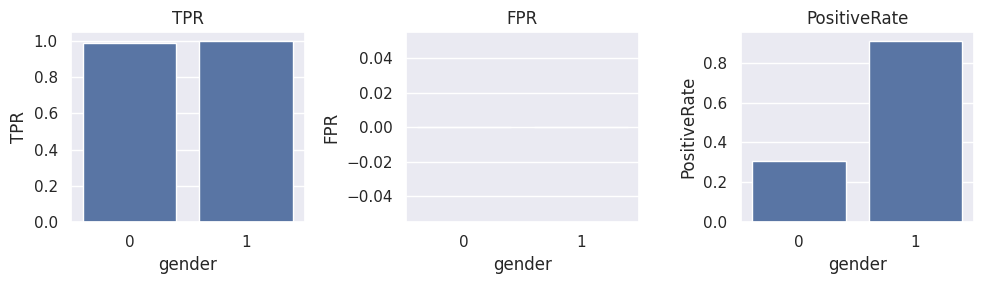

In [29]:
# Visualize disparity
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
for i, col in enumerate(['TPR', 'FPR', 'PositiveRate']):
    sns.barplot(data=metrics_df, x='gender', y=col, ax=ax[i])
    ax[i].set_title(col)
plt.tight_layout()
plt.show()

Bar plots highlight where the model favors one group (e.g., higher positive rate). Use to motivate mitigation (reweighting/thresholds).

## Part 2: Transformers in Minutes (pipelines)

Run sentiment analysis to show a Hugging Face pipeline working out of the box.

In [30]:
# Sentiment analysis with a pretrained model
sentiment = pipeline('sentiment-analysis')
sentiment(['Transformers are amazing!', 'This bug is '])

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


[{'label': 'POSITIVE', 'score': 0.9998725652694702},
 {'label': 'NEGATIVE', 'score': 0.9997885823249817}]

Pipeline loads tokenizer+model under the hood; returns label and confidence for each sentence.

Zero-shot classification scores each candidate label against the sentence using an NLI backbone.
The returned scores are probabilities; the top label is the model’s best guess.
You can add more labels or change them without retraining.

In [31]:
# Zero-shot classification: classify without training
zero_shot = pipeline('zero-shot-classification')
zero_shot(
    'We are exploring prompt engineering for teaching.',
    candidate_labels=['education', 'sports', 'finance']
)

No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


{'sequence': 'We are exploring prompt engineering for teaching.',
 'labels': ['education', 'sports', 'finance'],
 'scores': [0.9652037620544434, 0.017830202355980873, 0.016966070979833603]}

Zero-shot uses NLI under the hood to rank candidate labels—handy for quick tagging tasks.

Generate text with a small decoder-only model to see how a short prompt is extended.
Handy for illustrating next-token prediction and why prompt wording matters.
Keep prompts short here to stay fast on Colab.

In [32]:
# Text generation (small model for speed)
generator = pipeline('text-generation', model='distilgpt2')
generator('Once upon a time', max_length=10, num_return_sequences=1)

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=10) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[{'generated_text': 'Once upon a time of this writing I thought it would be interesting to see if there was a chance that the article would make its way to our screens and read on our screens. I actually thought that it would be interesting to see if there was a chance that the article would make its way to our screens and read on our screens. I actually thought that it would be interesting to see if there was a chance that the article would make its way to our screens and read on our screens. I actually thought that it would be interesting to see if there was a chance that the article would make its way to our screens and read on our screens.\n\n\n\nI did not know if the article would be good for our readers. I know that the article would be a good for our readers. I know that the article would be a good for our readers. I know that the article would be a good for our readers. I know that the article would be a good for our readers. I know that the article would be a good for our read

Runs a small GPT-2 variant and returns one continuation of ~40 tokens.
Notice how the output follows the style of the prompt; rerun with different prompts to compare.
Multiple returns can be requested by raising num_return_sequences.

Peek at toy attention scores so students can visualize words attending to each other.
We’ll use tiny embeddings for three tokens and plot their dot-product scores.
Brighter cells will indicate stronger similarity/attention.

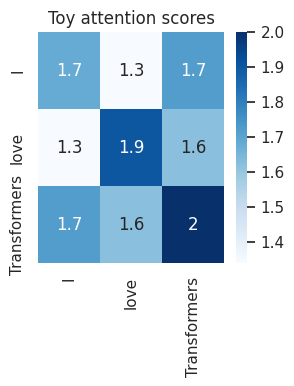

In [33]:
# Simple token-level attention heatmap (toy)
tokens = ['I', 'love', 'Transformers']
emb = np.array([[1., 0.2, 0.8], [0.9, 1., 0.3], [0.8, 0.6, 1.]])
attn_scores = emb @ emb.T
fig, ax = plt.subplots(figsize=(3,3))
sns.heatmap(attn_scores, annot=True, xticklabels=tokens, yticklabels=tokens, cmap='Blues', ax=ax)
ax.set_title('Toy attention scores')
plt.show()

This heatmap shows how much each word 'pays attention' to every other word.
Brighter blue = stronger connection. For example, 'I' and 'love' might have a high score (bright cell).
This is a simplified version - real transformers do this calculation millions of times with learned weights.
Key insight: transformers figure out which words are important to each other, not just word order.

## Part 3: Prompt Engineering Quick Wins

Compare two prompts (child vs grad student) to see how wording changes the generated response.
Both use the same underlying generator; only the prompt phrasing differs.
Scan the outputs for shifts in tone, vocabulary, and detail.

In [35]:
# Two prompts, different tones
gen = pipeline('text-generation', model='gpt2-medium')
prompts = [
    'Explain transformers to a 10-year-old in 3 short sentences:',
    'Explain transformers to a machine learning graduate student in 3 short sentences:'
]
for p in prompts:
    out = gen(p, max_length=60, num_return_sequences=1)[0]['generated_text']
    print('--- Prompt ---')
    print(p)
    print('--- Output ---')
    print(out)

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/m

--- Prompt ---
Explain transformers to a 10-year-old in 3 short sentences:
--- Output ---
Explain transformers to a 10-year-old in 3 short sentences: "Transformers are the most beautiful cars on the planet! They're made of glass, they're big, they're futuristic."

3. You will get a high score if you tell the truth. (Also, don't share your scores with anyone. It's a good idea to keep them secret.)

4. You can earn bonus points for sharing your score with someone who is not your age.

5. All of your answers will be added to your "Best of" list, where others can read them. (To get the points, you have to share your answer on Twitter.)

6. You can share your answer with anyone you want, including your friends.

7. You can share your answer with anyone you want, including your friends. Share the #AskMeBot hashtag on Twitter so everyone can see.

8. You can share your answer with anyone you want, including your friends. Share the #AskMeBot hashtag on Twitter so everyone can see. If you're no

In [37]:
from transformers import pipeline

# Load a basic text-generation model
gen = pipeline(
    "text-generation",
    model="gpt2-medium"
)

prompts = [
    "Explain transformers to a 10-year-old in 3 short sentences:",
    "Explain transformers to a machine learning graduate student in 3 short sentences:"
]

for p in prompts:
    output = gen(
        p,
        max_length=60,
        num_return_sequences=1,
        do_sample=True,
        temperature=0.7
    )[0]["generated_text"]

    print("----- Prompt -----")
    print(p)
    print("----- Output -----")
    print(output)
    print()

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/m

----- Prompt -----
Explain transformers to a 10-year-old in 3 short sentences:
----- Output -----
Explain transformers to a 10-year-old in 3 short sentences:

a. You've always wanted to be a doctor. How much more serious can it get?

b. You've always wanted to be a scientist. How much more serious can it get?

c. You've always wanted to be a photographer. How much more serious can it get?

d. You've always wanted to be a soldier. How much more serious can it get?

e. You've always wanted to be a lawyer. How much more serious can it get?

f. You've always wanted to be a doctor. How much more serious can it get?

g. You've always wanted to be a lawyer. How much more serious can it get?

h. You've always wanted to be a soldier. How much more serious can it get?

i. You've always wanted to be a lawyer. How much more serious can it get?

j. You've always wanted to be a lawyer. How much more serious can it get?

k. You've always wanted to be a politician. How much more serious can it get?

l

In [41]:
from transformers import pipeline

# Load model
generator = pipeline(
    "text-generation",
    model="gpt2-medium"
)

prompt = (
    "Role: Tutor\n"
    "Style: concise\n"
    "Task: Summarize why self-attention helps sequence models.\n"
    "Format:\n"
    "- Exactly 3 bullet points\n"
    "- One sentence per bullet\n"
    "- No introduction, no conclusion\n"
    "Answer:\n"
)

output = generator(
    prompt,
    max_length=120,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
    num_return_sequences=1
)[0]["generated_text"]

print(output)

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=120) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Role: Tutor
Style: concise
Task: Summarize why self-attention helps sequence models.
Format:
- Exactly 3 bullet points
- One sentence per bullet
- No introduction, no conclusion
Answer:
- The model is simple enough to understand without having to explain why self-attention is useful.
- There are many examples of self-attention that have been used in the literature to explain how to use it effectively.
- There are many examples of how self-attention is used in the real world.
- Self-attention can be used to improve performance, reduce errors, and reduce time spent on tasks.
- Self-attention can help with self-awareness, reduce stress, and reduce depression.
- Self-attention is useful in situations where it's not clear how to use it.
- Self-attention is useful when you are trying to solve a problem in the future.
- Self-attention is useful when you are trying to solve a problem in the present.
- Self-attention can help you to think clearly and efficiently.
- Self-attention can help you t

Compare the two outputs: the 10-year-old version uses simple words, the grad student version uses technical terms.
Same model, same code - only the prompt changed!
This is prompt engineering: getting better results by changing how you ask the question.
Tip: add words like 'simple', 'technical', 'formal', or 'casual' to steer the AI's writing style.

Use a role + constraint prompt to keep the model brief and structured (three bullet summary).
Role prompts set the persona; constraints set length/format.
Great for keeping outputs tight during demos.

In [40]:
from transformers import pipeline

# Load a more capable text-generation model
gen = pipeline(
    "text-generation",
    model="gpt2-medium" # Switched to gpt2-medium for better instruction following
)

prompts = [
    "Explain transformers to a 10-year-old in 3 short sentences:",
    "Explain transformers to a machine learning graduate student in 3 short sentences:"
]

for p in prompts:
    output = gen(
        p,
        max_new_tokens=50, # Explicitly setting max_new_tokens for better control over generated length
        num_return_sequences=1,
        do_sample=True,
        temperature=0.7
    )[0]["generated_text"]

    print("----- Prompt -----")
    print(p)
    print("----- Output -----")
    print(output)
    print()

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


----- Prompt -----
Explain transformers to a 10-year-old in 3 short sentences:
----- Output -----
Explain transformers to a 10-year-old in 3 short sentences:

"The transformers are made of metal and glass and are very big and heavy."

"I want to use them for the future."

"Do you want to ride on them?"

"I want to ride on

----- Prompt -----
Explain transformers to a machine learning graduate student in 3 short sentences:
----- Output -----
Explain transformers to a machine learning graduate student in 3 short sentences:

For machine learning, there are two types:

Regularization (a class of transformations)

Normalization (a class of transformations)

Regularization is the process of making a transformation so that it is better at something than



This prompt does two things: sets a role ('concise tutor') and adds a constraint ('exactly 3 bullet points').
The output should be short and structured - perfect for teaching or presentations.
Without the constraint, the model might ramble for paragraphs.
Try other roles like 'exam grader', 'friendly mentor', or 'strict professor' to change the tone.